# Functions

In [179]:
import os, sys
dir1 = os.path.dirname(os.path.abspath(''))
if not dir1 in sys.path: sys.path.append(dir1)

In [180]:
from utils.environment import setup_data_vars
setup_data_vars()

## Calculate Metrics

In [181]:
def get_id_from_path(path: str, needs_num=True):
    """Given a path, assume that it is the full path that points to the file name. The
    file nam ehsould contain a number indicating the id number. It should appear first.

    Args:
        path (str): A path to the file name or the file name itsself. 
        
        needs_num (bool, optional): If the path needs a number. If it doesn't and no
        number was found return 0, otherwise return the number found. Defaults to True.

    Raises:
        ValueError: If a number is required and no number was found in the path

    Returns:
        int: the number found in the path
    """
    import re
    # Assume that it is the full path that points to the file name. The file name
    # should contain a number indicating the id number. It should appear first
    numbers = re.findall('\d+', path.split('/')[-1])
    if needs_num and len(numbers) == 0:
        raise ValueError(f"Could not find a number in {path}")
    if not needs_num and len(numbers) == 0:
        return 0
    return int(numbers[0])

def stats_about_metrics(metrics_dictionary: dict):

    return_metrics_dictionary = dict()
    return_metrics_dictionary['mean'] = dict()

    for model, metrics in metrics_dictionary.items():
        return_metrics_dictionary['mean'][model] = dict()
        for metric, data in metrics.items():
            return_metrics_dictionary['mean'][model][metric] = np.mean(data)

    return return_metrics_dictionary

In [182]:
import matplotlib.pyplot as plt
import SimpleITK as sitk
from tqdm import tqdm
import numpy as np
from platipy.imaging.label.comparison import compute_metric_total_apl, compute_surface_dsc, compute_metric_hd

import json
import os
import pandas as pd

def calculate_for_MedSAM(model_path):
    dice = {0: [], 1: [], 2: []}
    hd = {0: [], 1: [], 2: []}
    volume_similarity = {0: [], 1: [], 2: []}
    apl = {0: [], 1: [], 2: []}
    surface_dsc = {0: [], 1: [], 2: []}

    # we assume that we've already recorded and saved the statistics in a file validation.csv
    # this will contain the validation data for that particular anatomy across all three axis

    df = pd.DataFrame(columns=['name', 'axis', 'dice', 'jaccard', 'volume_similarity', 'apl', 'surface_distance', 'hausdorff_distance'])

    # load in the processed data if it already exists
    if os.path.exists(os.path.join(model_path, 'validation.csv')):
        df = pd.read_csv(os.path.join(model_path, 'validation.csv'))
    else:
        raise ValueError("No validation data found for this model")
    
    # go through the pandas dataframe and aggregate the metrics into each of the dictionaries keyed by the axis.
     
    for _, row in df.iterrows():
        dice[row['axis']].append(row['dice'])
        hd[row['axis']].append(row['hausdorff_distance'])
        volume_similarity[row['axis']].append(row['volume_similarity'])
        apl[row['axis']].append(row['apl'])
        surface_dsc[row['axis']].append(row['surface_distance'])

    return dice, hd, volume_similarity, surface_dsc, apl

def calculate_for_UniverSeg(model_path):
    dice = {0: [], 1: [], 2: []}
    hd = {0: [], 1: [], 2: []}
    volume_similarity = {0: [], 1: [], 2: []}
    apl = {0: [], 1: [], 2: []}
    surface_dsc = {0: [], 1: [], 2: []}

    # we assume that we've already recorded and saved the statistics in a file validation.csv
    # this will contain the validation data for that particular anatomy across all three axis

    df = pd.DataFrame(columns=['name','dice','volume_similarity','apl','surface_distance','hausdorff_distance'])

    # go through each axis in the model path and load in the validation data

    axis_stats = sorted(os.listdir(model_path))
    assert len(axis_stats) == 3, "There should be 3 axis in the model path"

    for i, axis in enumerate(axis_stats):
        if os.path.exists(os.path.join(model_path, axis, 'validation.csv')):
            df = pd.read_csv(os.path.join(model_path, axis, 'validation.csv'))
        else:
            raise ValueError("No validation data found for this model")
    
        # go through the pandas dataframe and aggregate the metrics into each of the dictionaries keyed by the axis.
        
        for _, row in df.iterrows():
            dice[i].append(row['dice'])
            hd[i].append(row['hausdorff_distance'])
            volume_similarity[i].append(row['volume_similarity'])
            apl[i].append(row['apl'])
            surface_dsc[i].append(row['surface_distance'])

    return dice, hd, volume_similarity, surface_dsc, apl

In [183]:
def calculate_metrics(input_path_gt: str, input_path_pred: dict):
    """Will return the metrics for each prediction path

    Args:
        input_path_gt (str): a string to the ground truth 
        input_path_pred (dict): a dictionary containing the paths to the predictions

    Returns:
        dict: returns dictionary of metrics for the main prediction paths
    """

    # Get the list of predictions for each input_path_pred
    

    ground_truth = [os.path.join(input_path_gt, file) for file in sorted(filter(lambda x: '.nii.gz' in x, os.listdir(input_path_gt)))]
    assert len(ground_truth) == 100
    assert get_id_from_path(ground_truth[0]) == 1

    final_metrics = dict()
    for k, _ in input_path_pred.items(): final_metrics[k] = dict()

    overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()

    # Iterate over the models and their predictions
    for prediction_type, prediction_path in input_path_pred.items():

        dice = []
        hd = []
        volume_similarity = []
        apl = []
        surface_dsc = []

        if 'MedSAM' in prediction_type:
            # raise NotImplementedError("MedSAM is not decomissioned for the mean while")
            dice, hd, volume_similarity, surface_dsc, apl = calculate_for_MedSAM(prediction_path)
        elif 'UniverSeg' in prediction_type:
            dice, hd, volume_similarity, surface_dsc, apl = calculate_for_UniverSeg(prediction_path)
        else:
            # Extract all .nii.gz files for metric calculation
            predictions = [os.path.join(prediction_path, file) for file in sorted(filter(lambda x: '.nii.gz' in x, os.listdir(prediction_path)))]

            # Iterate over pairs of predictions and ground truth
            print(f'Calculating metrics for  {prediction_type}')
            for ypred in tqdm(predictions):
                y_gt = ground_truth[get_id_from_path(ypred) - 1]
                # If we wish to process the metrics as a 3D whole image, then this is
                # trivially done without loading each slice separately
                ypred_sitk = sitk.ReadImage(ypred)
                y_gt_sitk = sitk.ReadImage(y_gt)

                overlap_measures_filter.Execute(y_gt_sitk, ypred_sitk)

                dice.append(overlap_measures_filter.GetDiceCoefficient())
                hd.append(compute_metric_hd(y_gt_sitk, ypred_sitk))
                volume_similarity.append(overlap_measures_filter.GetVolumeSimilarity())
                surface_dsc.append(compute_surface_dsc(y_gt_sitk, ypred_sitk))
                apl.append(compute_metric_total_apl(y_gt_sitk, ypred_sitk))


        final_metrics[prediction_type]['DICE Similarity Coefficient'] = dice
        final_metrics[prediction_type]['Haussdorf Distance'] = hd
        final_metrics[prediction_type]['Relative Volume Difference'] = volume_similarity
        final_metrics[prediction_type]['Added Path Length'] = apl
        final_metrics[prediction_type]['Surface DSC'] = surface_dsc

    return final_metrics

In [184]:
def fetch_metric_for_class(class_id: int):
    """Prints a plot of the segmentations for the given class in the predefined format.
    This method acts in a factory pattern to generate the plot for each class. 

    Args:
        class_id (int): 1: Anorectum ... 5: Parametrium
    """

    setup_data_vars()

    classes = [os.environ.get('Anorectum')
             , os.environ.get('Bladder')
             , os.environ.get('CTVn')
             , os.environ.get('CTVp')
             , os.environ.get('Parametrium')
             , os.environ.get('Uterus')
             , os.environ.get('Vagina')]

    gt_labels = [os.path.join(os.environ.get('nnUNet_raw'), x, os.environ.get('data_trainingLabels')) for x in classes]
    # gt_labels = [os.path.join(os.environ.get('nnUNet_'), x, 'nnUNetPlans_3d_fullres') for x in classes]
    # print('WARNING: using old nnUNet predictions. Change to new path when complete')

    anorectum = {
        # 'nnUNet': os.path.join(os.environ.get('nnUNet_inference'), os.environ.get('Anorectum'), 'nnUNetTrainer_500epochs__nnUNetResEncUNetLPlans__3d_fullres'),
        # 'total segmentator (fine-tuned)': os.path.join(os.environ.get('TotalSegmentator_inference'), os.environ.get('Anorectum'), 'nnUNetTrainer_250epochs__totseg_nnUNetPlans__3d_fullres'),
        'UniverSeg out-of-the-box': '/vol/biomedic3/bglocker/ugproj2324/az620/radiotherapy/research/source/code/UniverSeg/results/Anorectum',
        'MedSAM boxed': os.path.join(os.environ.get('MedSAM_finetuned'), 'boxed_lowres_2', 'Anorectum'),
    }

    bladder = {
        'nnUNet': os.path.join(os.environ.get('nnUNet_inference'), os.environ.get('Bladder'), 'nnUNetTrainer_500epochs__nnUNetResEncUNetLPlans__3d_fullres'),
        'total segmentator': os.path.join(os.environ.get('TotalSegmentator_inference'), os.environ.get('Bladder'), 'nnUNetTrainer__nnUNetPlans__3d_fullres'),
        'total segmentator (fine-tuned)': os.path.join(os.environ.get('TotalSegmentator_inference'), os.environ.get('Bladder'), 'nnUNetTrainer_250epochs__totseg_nnUNetPlans__3d_fullres'),
        'MedSAM boxed': os.path.join(os.environ.get('MedSAM_finetuned'), 'boxed_lowres_2', 'Bladder'),
    }

    ctvn = {
        'nnUNet': os.path.join(os.environ.get('nnUNet_inference'), os.environ.get('CTVn'), 'nnUNetTrainer_500epochs__nnUNetResEncUNetLPlans__3d_fullres'),
        'total segmentator (fine-tuned)': os.path.join(os.environ.get('TotalSegmentator_inference'), os.environ.get('CTVn'), 'nnUNetTrainer_250epochs__totseg_nnUNetPlans__3d_fullres'),
        'MedSAM boxed': os.path.join(os.environ.get('MedSAM_finetuned'), 'boxed_lowres_2', 'CTVn'),
    }

    ctvp = {
        'nnUNet': os.path.join(os.environ.get('nnUNet_inference'), os.environ.get('CTVp'), 'nnUNetTrainer_500epochs__nnUNetResEncUNetLPlans__3d_fullres'),
        'total segmentator (fine-tuned)': os.path.join(os.environ.get('TotalSegmentator_inference'), os.environ.get('CTVp'), 'nnUNetTrainer_250epochs__totseg_nnUNetPlans__3d_fullres'),
        'MedSAM boxed': os.path.join(os.environ.get('MedSAM_finetuned'), 'boxed_lowres_2', 'CTVp'),
    }

    parametrium = {
        'nnUNet': os.path.join(os.environ.get('nnUNet_inference'), os.environ.get('Parametrium'), 'nnUNetTrainer_500epochs__nnUNetResEncUNetLPlans__3d_fullres'),
        'total segmentator (fine-tuned)': os.path.join(os.environ.get('TotalSegmentator_inference'), os.environ.get('Parametrium'), 'nnUNetTrainer_250epochs__totseg_nnUNetPlans__3d_fullres'),
        'MedSAM boxed': os.path.join(os.environ.get('MedSAM_finetuned'), 'boxed_lowres_2', 'Parametrium'),
    }

    uterus = {
        'nnUNet': os.path.join(os.environ.get('nnUNet_inference'), os.environ.get('Uterus'), 'nnUNetTrainer_500epochs__nnUNetResEncUNetLPlans__3d_fullres'),
        'total segmentator (fine-tuned)': os.path.join(os.environ.get('TotalSegmentator_inference'), os.environ.get('Uterus'), 'nnUNetTrainer_250epochs__totseg_nnUNetPlans__3d_fullres'),
        'MedSAM boxed': os.path.join(os.environ.get('MedSAM_finetuned'), 'boxed_lowres_2', 'Uterus'),
    }

    vagina = {
        'nnUNet': os.path.join(os.environ.get('nnUNet_inference'), os.environ.get('Vagina'), 'nnUNetTrainer_500epochs__nnUNetResEncUNetLPlans__3d_fullres'),
        'total segmentator (fine-tuned)': os.path.join(os.environ.get('TotalSegmentator_inference'), os.environ.get('Vagina'), 'nnUNetTrainer_250epochs__totseg_nnUNetPlans__3d_fullres'),
        'MedSAM boxed': os.path.join(os.environ.get('MedSAM_finetuned'), 'boxed_lowres_2', 'Vagina'),
    }

    predictions = [anorectum, bladder, ctvn, ctvp, parametrium, uterus, vagina]

    if 1 <= class_id <= len(predictions):
        return calculate_metrics(gt_labels[class_id - 1], predictions[class_id - 1])
    raise ValueError("Invalid class_id. Please choose a class between 1 and 5.")

## Plot the metrics

In [185]:
import shutil

tmp = []

def plot_metrics(metrics_dictionary: dict, organ_class: str, separate: bool = False, save: bool = False, showfliers = True, table = True, additional_title_context = '', separate_axis_medsam = False):
    """Plots the metrics for the given dictionary of metrics and prints a table of mean
    metrics to the right

    Args:
        metrics_dictionary (dict): A dictionary containing a key value pair of model type
        and value of dictionary. This dictionary will have a key value pairing of metric
        type and a list of values for that metric.
        
        organ_class (str): For saving the figure, supply the name of the organ class
        
        separate (bool, optional): Whether we print each type of model type separately or
        together so that for each metric we plot the models side by side for better
        comparison. Defaults to False.

        save (bool, optional): Whether to save the figure or not. Defaults to False.

        showfliers (bool, optional): Whether to show the outliers in the boxplot. Defaults
        to True.

        table (bool, optional): Whether to show the table of mean metrics or not. Defaults
        to True.

        additional_title_context (str, optional): Additional context to add to the title
        of the plot. Defaults to ''.


    """

    def draw_table(metric_result, ax, model_type):
        # Fetch statistics
        mean = [np.mean(result) for result in metric_result]
        std = [np.std(result) for result in metric_result]
        median = [np.median(result) for result in metric_result]

        # Format the table
        cell_text = []
        cell_text.append([f'{mean[i]:.2f}' for i in range(len(mean))])
        cell_text.append([f'{std[i]:.2f}' for i in range(len(std))])
        cell_text.append([f'{median[i]:.2f}' for i in range(len(std))])
        rowLabels = [r'$\hat{x}$', r'$\sigma$', r'$med$']

        import textwrap as twp
        max_line_width = 18
        colLabels = [twp.fill(label, max_line_width) for label in model_type]

        # Plot the table
        table_height = 0.05 * len(rowLabels)
        ax_box = ax.get_position()
        ax.set_position([ax_box.x0, ax_box.y0, ax_box.width, ax_box.height * (1 - table_height)])
        #  bbox=[0., 1., 1., table_height / (1 - table_height)] the position before
        table = ax.table(cell_text, cellLoc='center', rowLabels=rowLabels, colLabels=colLabels if not separate else None, fontsize=100) #, bbox=[0., 1., 1., table_height / (1 - table_height)] )
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1, 2)
        

    if separate and table:
        print('[WARNING]: Bug with table printing in the separate mode. Set table=False to avoid this.')

    augmented_metrics_dictionary = metrics_dictionary

    # If we have medsam predictions, for now, plot the different axese separately
    contains_medsam = ['MedSAM' in p or 'UniverSeg' in p for p in metrics_dictionary.keys()]
    # heuristic to check if we've already done this shebang
    if sum([1 for p in contains_medsam if p]) <= 3:
        if any(contains_medsam):
            # go over each model type and extract the metrics for each axis
            for i, _ in enumerate(contains_medsam):
                if not contains_medsam[i]: continue

                medsam_metric_type = list(metrics_dictionary.keys())[i]

                medsam_metrics = metrics_dictionary[medsam_metric_type]
                if separate_axis_medsam:
                    # Extract the metrics for each axis
                    set_of_processed_axis = set()
                    for metric in medsam_metrics.keys():
                        set_of_processed_axis.update(medsam_metrics[metric].keys())
                        for axis in medsam_metrics[metric].keys():
                            if f'{medsam_metric_type} (axis{axis})' not in augmented_metrics_dictionary.keys():
                                augmented_metrics_dictionary[f'{medsam_metric_type} (axis{axis})'] = dict()
                            augmented_metrics_dictionary[f'{medsam_metric_type} (axis{axis})'][metric] = medsam_metrics[metric][axis]

                    del augmented_metrics_dictionary[medsam_metric_type]

                # now include a global aggregate for each axis
                augmented_metrics_dictionary[medsam_metric_type] = dict()
                for metric in medsam_metrics.keys():
                    for axis in medsam_metrics[metric].keys():
                        if metric not in augmented_metrics_dictionary[medsam_metric_type].keys():
                            augmented_metrics_dictionary[medsam_metric_type][metric] = []
                        augmented_metrics_dictionary[medsam_metric_type][metric] += medsam_metrics[metric][axis]



    num_models = len(augmented_metrics_dictionary)

    nrows = num_models if separate == True else 1
    metrics_names = [list(augmented_metrics_dictionary[m].keys()) for m in augmented_metrics_dictionary.keys()]
    metrics_names = sorted(list(set([metric for model_metrics in metrics_names for metric in model_metrics])))
    ncols = len(metrics_names)

    plot_height = 5*1.6
    plot_width = 2*1.6

    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(plot_width * (ncols + num_models - 1), nrows * plot_height))

    # Reshape axes to be a 2D array
    axes = np.reshape(axes, (nrows, ncols))

    for i, row in enumerate(axes):
        for j, ax in enumerate(row):
            # << Fetch Data Collections For Plotting >>

            # Get the model type for printing. If we're not separating models, model_type
            # is a list of all model names
            model_type = list(augmented_metrics_dictionary.keys())[i] if separate else list(augmented_metrics_dictionary.keys())
            # Get the metric type for the current column. Its possible that this metric
            # doesn't exist for all models
            metrics_type = metrics_names[j]
            # Get the data for the current metric type while checking if it exists for the
            # current model
            getData = lambda m: augmented_metrics_dictionary[m][metrics_type] if metrics_type in augmented_metrics_dictionary[m].keys() else []
            metric_result = getData(model_type) if separate else [getData(model) for model in augmented_metrics_dictionary.keys()]
            
            metric_result = [np.array(m) for m in metric_result]
            metric_result = [m[~np.isnan(m)] for m in metric_result]
            
            # if len(metric_result.shape) == 1:
            #     metric_result = metric_result[None, :]

            # << Plot the Data >>

            # ax.violinplot(metric_result)
            ax.boxplot(metric_result, showfliers=showfliers, meanline=True, showmeans=True, patch_artist=True, widths=(.4))

            # << Plot Table with Mean Metrics >>
            
            if table:
                draw_table(np.reshape(metric_result, (1, -1)).tolist() if separate else metric_result, ax, model_type) 

            # << Axis Formatting >>

            ax.set_title(metrics_type.capitalize(), fontsize='x-large') # y=1.02,
            # TODO: Bug with separable mode. The x-axis labels are not being removed
            ax.set_xticklabels([] if table else model_type, rotation=30) #  if not separate else model_type, rotation=30
            ax.tick_params(axis='x', which='both', bottom=False)
    
    if separate:
        for ax, title in zip(axes[:,0], augmented_metrics_dictionary.keys()):
            ax.set_ylabel(title.capitalize(), fontsize='xx-large')
    
    # if organ class like Dataset000_classname, extract classname
    import re
    match = re.search(r'Dataset\d+_(\w+)', organ_class)
    if match:
        organ_class = match.group(1).lower()

    fig.tight_layout()
    fig.set_facecolor('silver')
    fig.suptitle(f'Segmentation metrics for the {organ_class.capitalize()} class {additional_title_context}', y=1, fontsize='xx-large', verticalalignment='center', horizontalalignment='center')  # Set the title of the whole plot
    fig.subplots_adjust(top=0.88)  # Adjust the plot to make room for the title

    # << Saving the Figure >>

    if save: 
        number = max([0] + [get_id_from_path(fn, False) for fn in os.listdir('metrics/') if fn.startswith(f'metrics{organ_class}')])

        file_name = lambda num: f'metrics{organ_class}_{f"{num}_"if num is not None else ""}{"separated" if separate else "combined"}_{"_".join(additional_title_context.split(" "))}.png'

        try:
            # Move the file
            os.makedirs('metrics/old', exist_ok=True)
            plt.savefig(f'metrics/{file_name(number + 1)}', bbox_inches='tight')
            shutil.move(f'metrics/{file_name(number)}', f'metrics/old/')
        except FileNotFoundError as e:
            print(f'WARNING: {e}')
    
    else:
        plt.show()

    

# Plotting Section

In [186]:
metrics = {}

Fetching metrics for  Dataset001_Anorectum  id  1


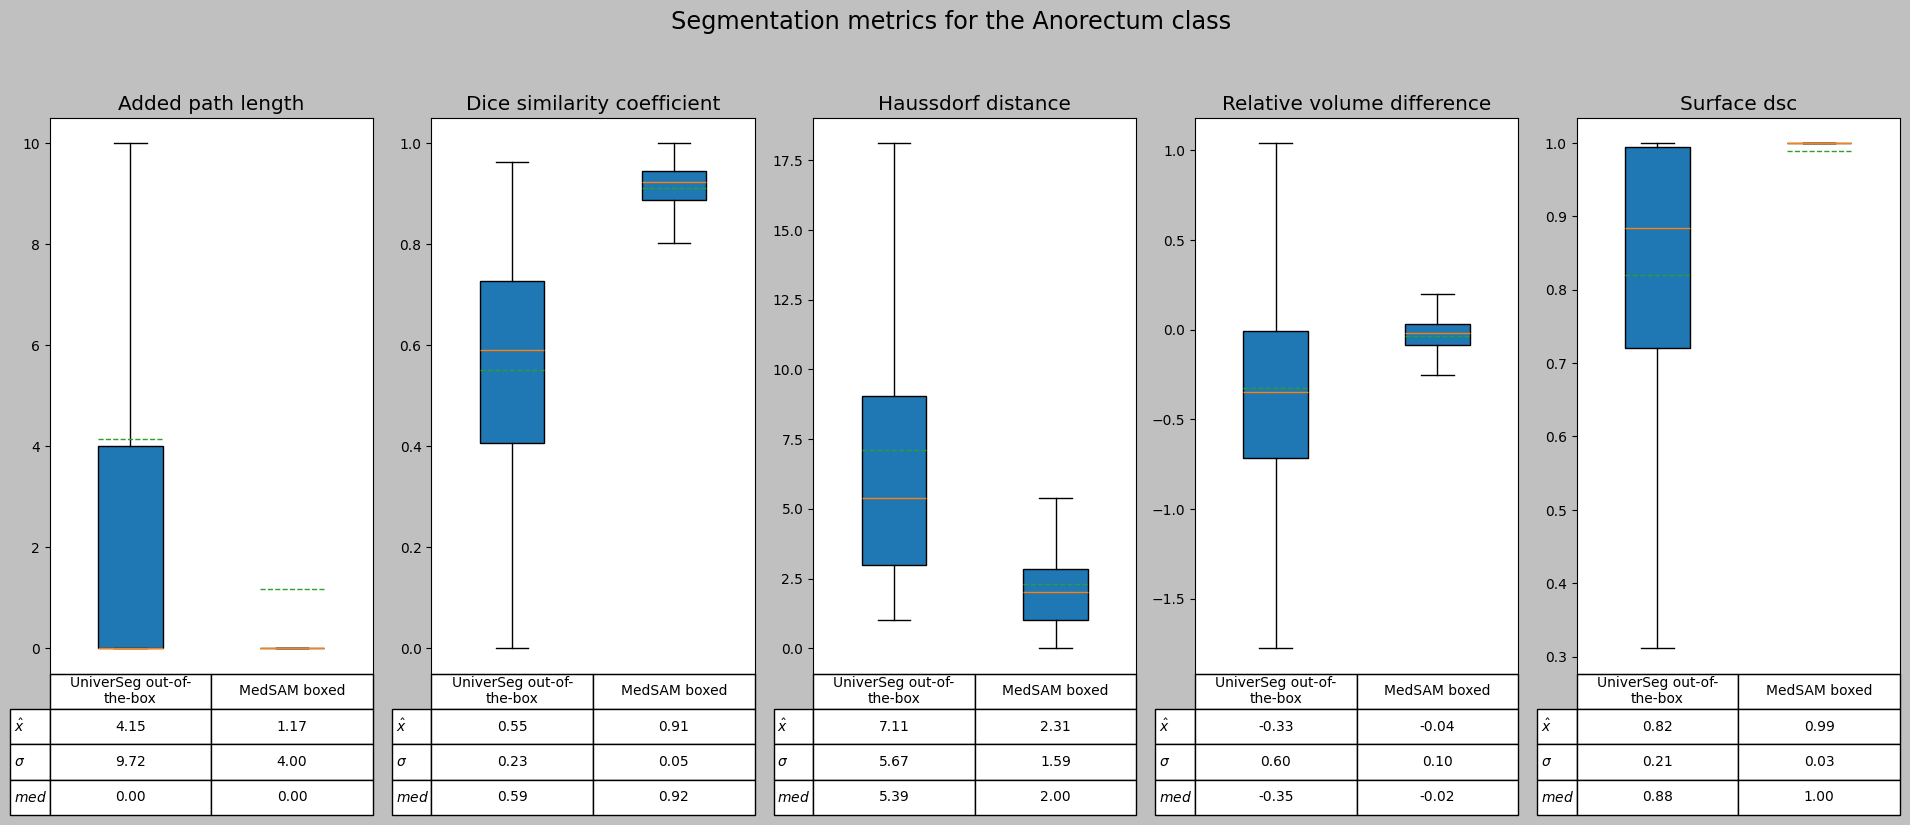

In [187]:
save = False
separate = False
table = True

for c in [
             os.environ.get('Anorectum'),
            #  os.environ.get('Bladder'),
            #  os.environ.get('CTVn'),
            #  os.environ.get('CTVp'),
            #  os.environ.get('Parametrium'),
            #  os.environ.get('Uterus'),
            #  os.environ.get('Vagina'),
             ]:
    id = int(c.split('_')[0][len('Dataset'):])
    print('Fetching metrics for ', c, ' id ', id)
    # check if c has already been processed
    # if c not in metrics.keys():
    metrics[c] = fetch_metric_for_class(id)
    plot_metrics(metrics[c], c, save=save, separate=separate, table=table, showfliers=False)

anorectum_metrics = None if os.environ.get('Anorectum') not in metrics.keys() else metrics[os.environ.get('Anorectum')]
bladder_metrics = None if os.environ.get('Bladder') not in metrics.keys() else metrics[os.environ.get('Bladder')]
ctvn_metrics = None if os.environ.get('CTVn') not in metrics.keys() else metrics[os.environ.get('CTVn')]
ctvp_metrics = None if os.environ.get('CTVp') not in metrics.keys() else metrics[os.environ.get('CTVp')]
parametrium_metrics = None if os.environ.get('Parametrium') not in metrics.keys() else metrics[os.environ.get('Parametrium')]
uterus_metrics = None if os.environ.get('Uterus') not in metrics.keys() else metrics[os.environ.get('Uterus')]
vagina_metrics = None if os.environ.get('Vagina') not in metrics.keys() else metrics[os.environ.get('Vagina')]

# anorectum_metrics_ax0 = fetch_metric_for_class(1, axis=0)
# bladder_metrics_ax0 = fetch_metric_for_class(2, axis=0)
# ctvn_metrics_ax0 = fetch_metric_for_class(3, axis=0)  
# ctvp_metrics_ax0 = fetch_metric_for_class(4, axis=0)
# parametrium_metrics_ax0 = fetch_metric_for_class(5, axis=0)

# anorectum_metrics_ax1 = fetch_metric_for_class(1, axis=1)
# bladder_metrics_ax1 = fetch_metric_for_class(2, axis=1)
# ctvn_metrics_ax1 = fetch_metric_for_class(3, axis=1)
# ctvp_metrics_ax1 = fetch_metric_for_class(4, axis=1)
# parametrium_metrics_ax1 = fetch_metric_for_class(5, axis=1)

# anorectum_metrics_ax2 = fetch_metric_for_class(1, axis=2)
# bladder_metrics_ax2 = fetch_metric_for_class(2, axis=2)
# ctvn_metrics_ax2 = fetch_metric_for_class(3, axis=2)
# ctvp_metrics_ax2 = fetch_metric_for_class(4, axis=2)
# parametrium_metrics_ax2 = fetch_metric_for_class(5, axis=2)

In [188]:
# new = tmp[0][~np.isnan(tmp[0])]

new = np.array(tmp)
print(np.any(np.isnan(new)))
new = new[~np.isnan(new)]
print(np.any(np.isnan(new)))

new = list(tmp)

print(new)



# new = tmp[~np.isnan(tmp)]

False
False
[]
